<a href="https://colab.research.google.com/github/tomonari-masada/course2025-sml/blob/main/05_nearest_neighbors_2_%E6%8E%88%E6%A5%AD%E4%B8%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k近傍法 (2)
* 今回は、複数の特徴量を使って、k近傍法で予測をおこなう。

## 準備

### インポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

### データファイル

* `lifesat_extended.csv`をアップロードする。

In [ ]:
from google.colab import files
files.upload()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/data/lifesat_extended.csv", index_col="Country")
df

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,GDP per capita
Country,,,,,,,,,,,,,,,,,,,,,
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,9054.914
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,9437.372
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,12239.894
Poland,33.0,1.4,10.8,3.2,90.0,7.41,60.0,0.9,17852.0,10919.0,...,22655.0,91.0,1.1,58.0,521.0,14.20,55.0,79.0,18.4,12495.334
Slovak Republic,13.0,3.0,6.6,0.6,92.0,7.02,60.0,1.2,17503.0,8663.0,...,20307.0,90.0,1.1,66.0,472.0,14.99,59.0,81.0,16.3,15991.736
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5,17288.083
Greece,27.0,3.7,6.5,0.7,68.0,6.16,49.0,1.6,18575.0,14579.0,...,25503.0,83.0,1.2,74.0,466.0,14.91,64.0,69.0,18.6,18064.288
Portugal,18.0,5.7,6.5,0.9,38.0,9.62,61.0,1.1,20086.0,31245.0,...,23688.0,86.0,1.6,46.0,488.0,14.95,58.0,86.0,17.6,19121.592
Slovenia,26.0,3.9,10.3,0.5,85.0,5.63,63.0,0.4,19326.0,18465.0,...,32037.0,90.0,1.5,65.0,499.0,14.62,52.0,88.0,18.4,20732.482


* 日本をテストデータとして除外し、残りのデータ集合を使う。

In [4]:
df_train = df.drop(['Japan'])
df_test = df.loc[['Japan']]

In [5]:
df_train

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,GDP per capita
Country,,,,,,,,,,,,,,,,,,,,,
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,9054.914
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,9437.372
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,12239.894
Poland,33.0,1.4,10.8,3.2,90.0,7.41,60.0,0.9,17852.0,10919.0,...,22655.0,91.0,1.1,58.0,521.0,14.20,55.0,79.0,18.4,12495.334
Slovak Republic,13.0,3.0,6.6,0.6,92.0,7.02,60.0,1.2,17503.0,8663.0,...,20307.0,90.0,1.1,66.0,472.0,14.99,59.0,81.0,16.3,15991.736
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5,17288.083
Greece,27.0,3.7,6.5,0.7,68.0,6.16,49.0,1.6,18575.0,14579.0,...,25503.0,83.0,1.2,74.0,466.0,14.91,64.0,69.0,18.6,18064.288
Portugal,18.0,5.7,6.5,0.9,38.0,9.62,61.0,1.1,20086.0,31245.0,...,23688.0,86.0,1.6,46.0,488.0,14.95,58.0,86.0,17.6,19121.592
Slovenia,26.0,3.9,10.3,0.5,85.0,5.63,63.0,0.4,19326.0,18465.0,...,32037.0,90.0,1.5,65.0,499.0,14.62,52.0,88.0,18.4,20732.482


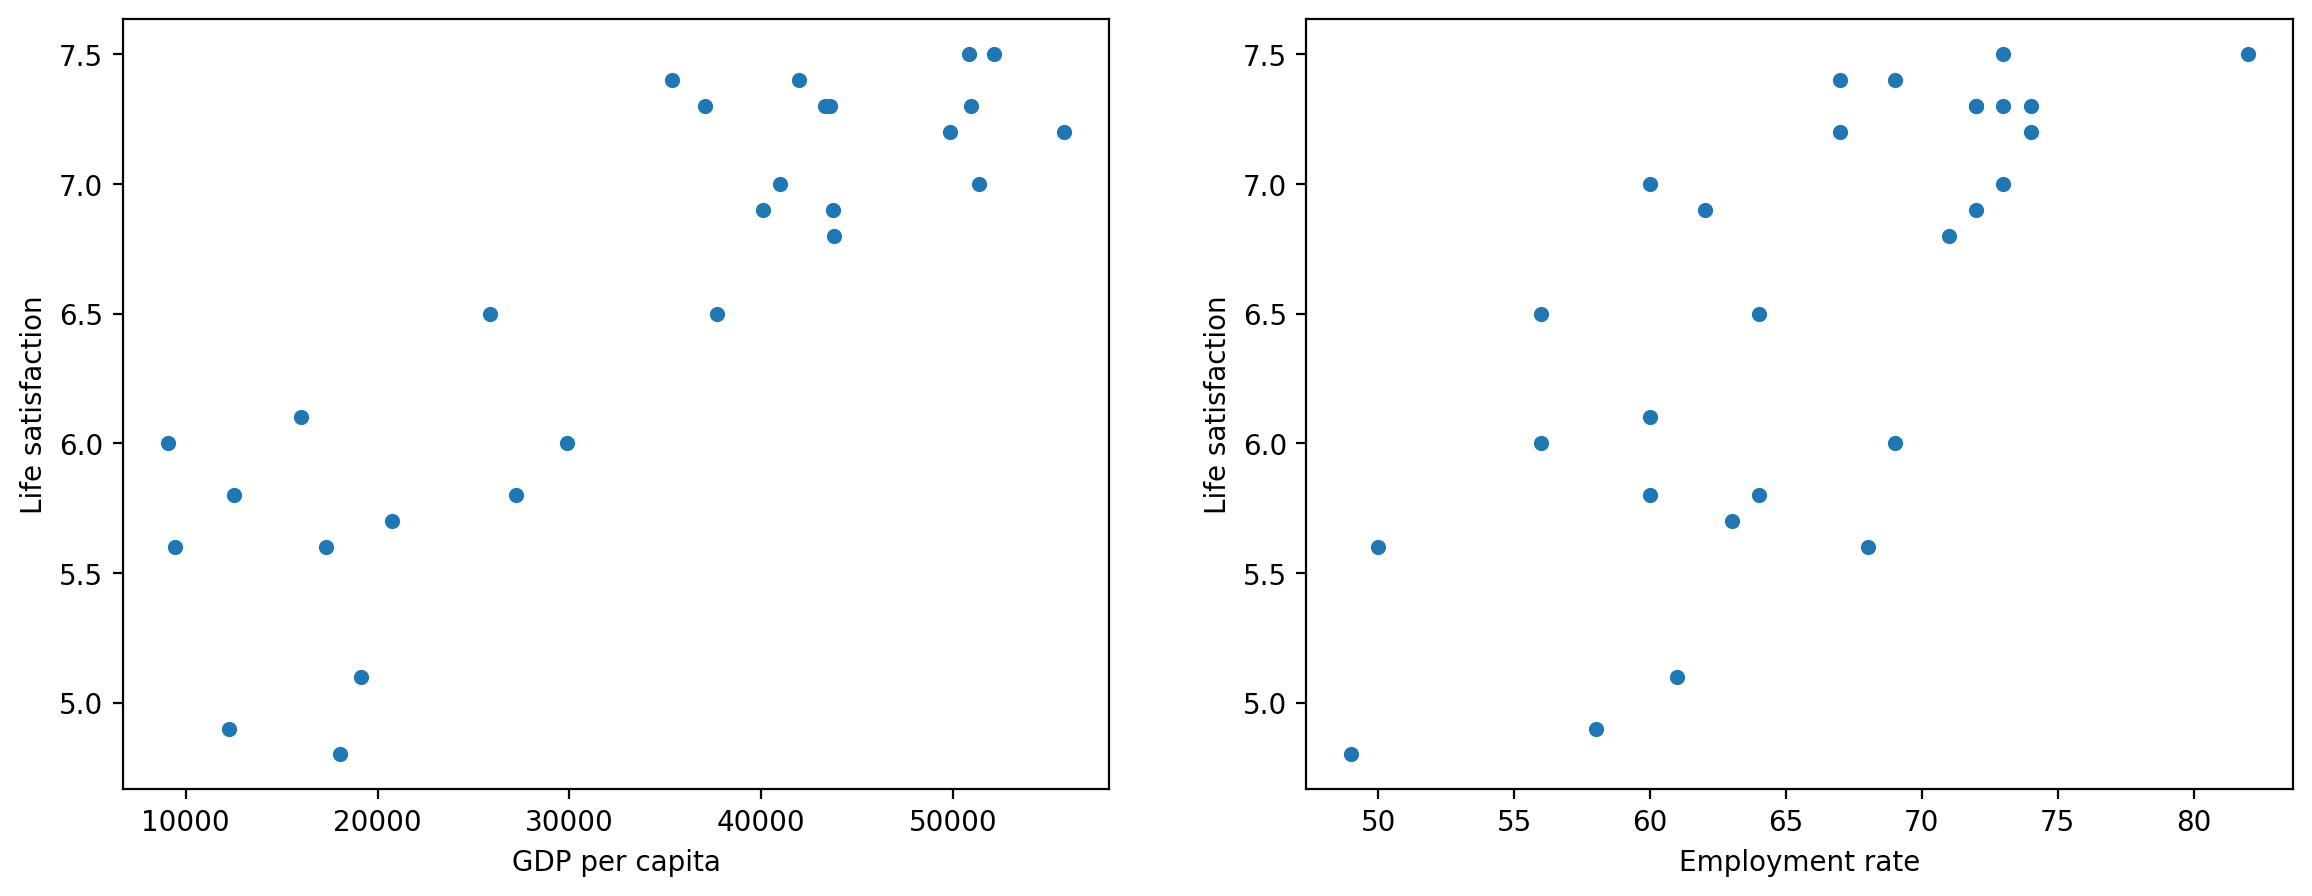

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
df_train.plot(kind='scatter', x='GDP per capita', y='Life satisfaction', ax=ax[0])
df_train.plot(kind='scatter', x='Employment rate', y='Life satisfaction', ax=ax[1]);

In [7]:
X = df_train[['GDP per capita', 'Employment rate']]
y = df_train['Life satisfaction']

In [8]:
X

,GDP per capita,Employment rate
Country,,
Russia,9054.914,69.0
Turkey,9437.372,50.0
Hungary,12239.894,58.0
Poland,12495.334,60.0
Slovak Republic,15991.736,60.0
Estonia,17288.083,68.0
Greece,18064.288,49.0
Portugal,19121.592,61.0
Slovenia,20732.482,63.0


## 今回の設定: 複数の特徴量を同時に使う
* 前回は、一人当たりのGDPと、雇用率を、別々に使った。
* 今回は、これら二つの特徴量を、同時に使いたい。
* つまり、(一人当たりのGDP, 雇用率)という2次元ベクトルを使って、生活満足度を予測したい。

### 演習問題1
* 韓国とイタリアの距離を、一人当たりのGDPと雇用率を同時に使って計算したい。
* しかし、下に示す距離の計算方法には、問題がある。どのような問題があるか。

In [9]:
print(np.linalg.norm(X.loc['Korea'] - X.loc['Italy']))

2671.395978782627


In [18]:
diff = X.loc['Korea'].values - X.loc['Italy'].values
np.sqrt(diff[0] ** 2 + diff[1] ** 2)

np.float64(2671.395978782627)

### 演習問題2
* 上で見つけた問題を解決した上で、あらためて、韓国とイタリアの距離を求めてみよう。

スケーリング
* 標準化

In [28]:
X_scaled_1 = (X - X.mean()) / X.std()
print(np.linalg.norm(X_scaled_1.loc['Korea'] - X_scaled_1.loc['Italy']))

1.0358396600947575


In [29]:
X_scaled_2 = (X - X.min()) / (X.max() - X.min())
print(np.linalg.norm(X_scaled_2.loc['Korea'] - X_scaled_2.loc['Italy']))

0.24906760120368357


In [24]:
(X - X.min()) / (X.max() - X.min())

,GDP per capita,Employment rate
Country,,
Russia,0.000000,0.606061
Turkey,0.008181,0.030303
Hungary,0.068127,0.272727
Poland,0.073591,0.333333
Slovak Republic,0.148380,0.333333
Estonia,0.176109,0.575758
Greece,0.192713,0.000000
Portugal,0.215329,0.363636
Slovenia,0.249786,0.424242


## 訓練データ/検証データ/テストデータ


### テストデータ (test set)
* 最終的にそれについて予測を行なうことで、手法の評価をおこないたいデータを、テストデータと呼ぶ。
* よって、今回は、日本のデータが、テストデータになる。
 * 普通は、テストデータは今回のように一つだけではなく、複数、用意する。
 * 今回は、データ数そのものが29個と少ないため、テストデータは一つだけにしている。

### 検証データ (validation set / development set)

* 最適な近傍の個数kを、どうやって求めたらいいだろうか。
* kの値を変えながら、日本の生活満足度を予測しつつ・・・
* その日本の予測誤差を見ながらkを決めるのでは、カンニングしていることになる。
 * テストデータでの評価は、最終評価なので、最後に一度行うだけ。
 * つまり、テストデータについては、答えが分かっていないと想定する。
* 日本の生活満足度を予測する前に、どのようにしてkを決めればいいだろうか。


* そこで、テストデータ以外のデータを使って、予測問題を解き、評価する。

* テストデータ以外のデータの中から、国を一つ選んで（例えば韓国）、その国について予測をしてみる。
* k近傍法の場合のkのように、チューニングしなければならないハイパーパラメータを決めるために使うデータを、検証データと呼ぶ。
 * 本当にそれについて予測をしたいデータは、テストデータ。
 * 検証(validation)のためにそれについて予測をおこなうデータが、検証データ。
* 検証データについて予測を行うことで、kの値を変えたとき予測性能がどう変わるか、調べる。
 * 検証データも、普通は、複数個用意する。
 * 今回は、データ数そのものが少ないため、検証データも一つだけにしている。


### 訓練データ (training set)
* 予測を実行するための手掛かりとする使うデータ集合を、訓練データと呼ぶ。
* k近傍法では、その中から特定の国の近傍をk個見つけてくるデータ集合が、訓練データになる。

## 最適なkの決定
* ここでは、韓国を検証データとして使う。
 * 日本はテストデータなので、最初に除外しておいた。
* そして、韓国の生活満足度を予測し、最も良い予測値を与えるkがいくらか、調べる。

### 演習問題3
* 韓国の生活満足度を予測し、最も良い予測値を与えるkを調べよう。

In [31]:
# ヒント：韓国だけ検証データとして取り分けておくコード
validation_set = ["Korea"]
X_train = X.drop(validation_set)
y_train = y.drop(validation_set)
X_val = X.loc[validation_set]
y_val = y.loc[validation_set]

In [35]:
X_train_standard = (X_train - X_train.mean()) / X_train.std()
X_val_standard = (X_val - X_train.mean()) / X_train.std()

In [47]:
sorted_countries = ((X_train_standard - X_val_standard.squeeze()) ** 2).sum(axis=1).sort_values().index
sorted_countries

Index(['Slovenia', 'Portugal', 'Israel', 'France', 'Estonia', 'Belgium',
       'Slovak Republic', 'Spain', 'Italy', 'Poland', 'Finland', 'Hungary',
       'New Zealand', 'Russia', 'United Kingdom', 'Germany', 'Canada',
       'Austria', 'Netherlands', 'Ireland', 'Australia', 'United States',
       'Sweden', 'Greece', 'Denmark', 'Turkey', 'Iceland'],
      dtype='object', name='Country')

In [57]:
len(sorted_countries)

27

In [62]:
best_k = 0
best_error = np.inf
for k in range(1, len(sorted_countries) + 1):
  prediction = y_train[sorted_countries[:k]].mean()
  error = (y_val - prediction).abs().values[0]
  if error < best_error:
    best_k = k
    best_error = error
  print(f"k={k} error={error:.3f}")
print(f"best k={best_k}")

k=1 error=0.100
k=2 error=0.400
k=3 error=0.267
k=4 error=0.375
k=5 error=0.260
k=6 error=0.400
k=7 error=0.386
k=8 error=0.425
k=9 error=0.400
k=10 error=0.360
k=11 error=0.473
k=12 error=0.358
k=13 error=0.446
k=14 error=0.429
k=15 error=0.467
k=16 error=0.513
k=17 error=0.571
k=18 error=0.600
k=19 error=0.647
k=20 error=0.675
k=21 error=0.714
k=22 error=0.745
k=23 error=0.774
k=24 error=0.700
k=25 error=0.740
k=26 error=0.704
k=27 error=0.741
best k=1


In [66]:
X_train_minmax = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val_minmax = (X_val - X_train.min()) / (X_train.max() - X_train.min())

In [67]:
sorted_countries = ((X_train_minmax - X_val_minmax.squeeze()) ** 2).sum(axis=1).sort_values().index
sorted_countries

Index(['Slovenia', 'Portugal', 'Israel', 'France', 'Spain', 'Estonia', 'Italy',
       'Slovak Republic', 'Belgium', 'Poland', 'New Zealand', 'Finland',
       'Hungary', 'Germany', 'United Kingdom', 'Russia', 'Canada', 'Austria',
       'Netherlands', 'Greece', 'Ireland', 'Australia', 'Turkey', 'Sweden',
       'Denmark', 'United States', 'Iceland'],
      dtype='object', name='Country')

In [68]:
best_k = 0
best_error = np.inf
for k in range(1, len(sorted_countries) + 1):
  prediction = y_train[sorted_countries[:k]].mean()
  error = (y_val - prediction).abs().values[0]
  if error < best_error:
    best_k = k
    best_error = error
  print(f"k={k} error={error:.3f}")
print(f"best k={best_k}")

k=1 error=0.100
k=2 error=0.400
k=3 error=0.267
k=4 error=0.375
k=5 error=0.440
k=6 error=0.333
k=7 error=0.314
k=8 error=0.313
k=9 error=0.400
k=10 error=0.360
k=11 error=0.464
k=12 error=0.558
k=13 error=0.446
k=14 error=0.500
k=15 error=0.533
k=16 error=0.513
k=17 error=0.571
k=18 error=0.600
k=19 error=0.647
k=20 error=0.565
k=21 error=0.595
k=22 error=0.636
k=23 error=0.600
k=24 error=0.633
k=25 error=0.676
k=26 error=0.704
k=27 error=0.741
best k=1


## 交差検証 (cross-validation)
* 検証データの取り方を何通りも変えつつ予測手法の評価を繰り返すことで・・・
* 手法の性能を検証することを交差検証と呼ぶ。

## leave-one-out交差検証 (1)
* 上では、韓国を検証データとして使った。
* しかし、韓国以外の国を検証データとしても構わないはずである。
* そこで、日本以外の国の一つ一つを検証データとした場合の、それぞれ最適なkの値を求めてみる。
  * 検証データが1個の場合の交差検証を、leave-one-out交差検証と呼ぶ。

### 演習問題4
* 韓国について行ったことと同じことを、他の国についても実行し・・・
* 最適なkの値がどのくらい違ってくるか、調べてみよう。

In [106]:
def train_val_split(X, validation_set):
  X_train = X.drop(validation_set)
  y_train = y.drop(validation_set)
  X_val = X.loc[validation_set]
  y_val = y.loc[validation_set]
  return X_train, y_train, X_val, y_val

In [91]:
def standard_scaler(X_train, X_val):
  X_train_scaled = (X_train - X_train.mean()) / X_train.std()
  X_val_scaled = (X_val - X_train.mean()) / X_train.std()
  return X_train_scaled, X_val_scaled

In [92]:
def minmax_scaler(X_train, X_val):
  X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min())
  X_val_scaled = (X_val - X_train.min()) / (X_train.max() - X_train.min())
  return X_train_scaled, X_val_scaled

In [104]:
def knn_prediction(sorted_countries, y_train, y_val):
  best_k = 0
  best_error = np.inf
  for k in range(1, len(sorted_countries) + 1):
    prediction = y_train[sorted_countries[:k]].mean()
    error = (y_val - prediction).abs().values[0]
    if error < best_error:
      best_k = k
      best_error = error
  return best_k, best_error

In [108]:
for country in X.index:
  X_train, y_train, X_val, y_val = train_val_split(X, validation_set=[country])
  X_train_standard, X_val_standard = standard_scaler(X_train, X_val)
  squared_norm = ((X_train_standard - X_val_standard.squeeze()) ** 2).sum(axis=1)
  sorted_countries = squared_norm.sort_values().index
  best_k, best_error = knn_prediction(sorted_countries, y_train, y_val)
  print(f"{country}: k={best_k} error={best_error:.3f}")

Russia: k=10 error=0.020
Turkey: k=7 error=0.000
Hungary: k=7 error=0.757
Poland: k=13 error=0.046
Slovak Republic: k=16 error=0.019
Estonia: k=4 error=0.050
Greece: k=1 error=0.800
Portugal: k=4 error=0.525
Slovenia: k=4 error=0.000
Spain: k=27 error=0.015
Korea: k=1 error=0.100
Italy: k=13 error=0.008
Israel: k=2 error=0.450
New Zealand: k=10 error=0.090
France: k=25 error=0.012
Belgium: k=2 error=0.050
Germany: k=17 error=0.006
Finland: k=7 error=0.257
Canada: k=10 error=0.090
Netherlands: k=11 error=0.064
Austria: k=18 error=0.028
United Kingdom: k=20 error=0.005
Sweden: k=10 error=0.000
Iceland: k=3 error=0.167
Australia: k=2 error=0.050
Ireland: k=4 error=0.000
Denmark: k=1 error=0.200
United States: k=6 error=0.000


* 最適なkを、どのようにして決めればいいだろうか？
 * 例えば、各国について得られたkの平均をとることが考えられるが、これは良い方法と言えるだろうか？

## leave-one-out交差検証 (2)
* 上では、テストデータである日本を除く国を、一つずつ順番に検証データとして、最適なkを求めた。
* しかし、こうして国ごとに求められたkを、どうやってまとめあげるのか、疑問が残った。
 * それらkの平均をとる、という方法は、何かおかしい感じがする。
 * 最頻値の方が、まだましであろう。
* 最適なkを決める、もっと良い方法はないだろうか？

### 演習問題5
* 韓国を検証データとする。つまり、韓国について予測を行なう。k=1から27まで変えたとき、それぞれ予測誤差がいくらになるか、求めてみよう。

In [113]:
len(X.index)

28

In [114]:
def knn_prediction(sorted_countries, y_train, y_val):
  errors = []
  for k in range(1, len(sorted_countries) + 1):
    prediction = y_train[sorted_countries[:k]].mean()
    errors.append((y_val - prediction).abs().values.item(0))
  return np.array(errors)

In [116]:
country = "Russia"
X_train, y_train, X_val, y_val = train_val_split(X, validation_set=[country])
X_train_standard, X_val_standard = standard_scaler(X_train, X_val)
squared_norm = ((X_train_standard - X_val_standard.squeeze()) ** 2).sum(axis=1)
sorted_countries = squared_norm.sort_values().index
errors = knn_prediction(sorted_countries, y_train, y_val)
errors

array([0.4       , 0.35      , 0.3       , 0.45      , 0.34      ,
       0.46666667, 0.42857143, 0.2       , 0.12222222, 0.02      ,
       0.06363636, 0.05833333, 0.13076923, 0.22142857, 0.26666667,
       0.225     , 0.28823529, 0.31666667, 0.34736842, 0.395     ,
       0.31904762, 0.35909091, 0.4       , 0.44583333, 0.468     ,
       0.49615385, 0.53333333])

### 演習問題6
* 縦が国名、横がkの値の表を、データフレームとして作った上で・・・
* 日本を除く28カ国の一つ一つを検証データとして評価していくことで・・・
* 各々のkの値で予測誤差がいくらになるかで、表を埋めてみよう。

In [ ]:
prediction_errors = {}
for country in X.index:
  validation_set = [country]
  X_train, y_train, X_val, y_val = train_val_split(X, validation_set=validation_set)
  X_train_standard, X_val_standard = standard_scaler(X_train, X_val)
  squared_norm = ((X_train_standard - X_val_standard.squeeze()) ** 2).sum(axis=1)
  sorted_countries = squared_norm.sort_values().index
  prediction_errors[country] = knn_prediction(sorted_countries, y_train, y_val)

In [ ]:
df_errors = pd.DataFrame.from_dict(prediction_errors)
df_errors

### 演習問題7
* 上で作った表で、それぞれのkの値について、予測誤差の平均値を求めてみよう。

### 演習問題8
* 上で求めた予測誤差の平均値を、最も小さくするkの値は？

### 演習問題9
* こうして求めた最適なkを使って、最終的に、日本の生活満足度の予測をしてみよう。
  * ここで初めてテストデータを使う。

# 課題
* 上のnotebookを最後まで実践することが、今回の課題です。